In [1]:
#hide
#default_exp dev.rdf

# RDF Representation

This notebook documents the creation of helper functions for generating an RDF representation of the BMRS API from its OpenAPI representation.

<br>

### Imports

In [28]:
#exports
import yaml
import requests
import matplotlib.pyplot as plt

from datacatalogtordf import Catalog
from oastodcat import OASDataService

import networkx as nx
from rdflib import Graph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph

In [3]:
def create_id(s: str) -> str:
    """Helper function to create unique ids based on input str s."""
    return hashlib.sha1(str.encode(s)).hexdigest()  # noqa: S303


class Error(Exception):
    """Base class for exceptins in this module."""

    pass


class NotValidOASError(Error):
    """The specification object is not valid.
    Attributes:
        message -- explanation of the error
    """

    def __init__(self, message: str) -> None:
        """Inits an object with default values."""
        self.message = message


class NotSupportedOASError(Error):
    """We do not support this version of the specification.
    Attributes:
        message -- explanation of the error
    """

    def __init__(self, message: str) -> None:
        """Inits an object with default values."""
        self.message = message


class RequiredFieldMissingError(Error):
    """A required filed is missing.
    Attributes:
        message -- explanation of the error
    """

    def __init__(self, message: str) -> None:
        """Inits an object with default values."""
        self.message = message

In [60]:
dataset = Dataset()

dir(dataset)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_abc_impl',
 '_access_rights',
 '_access_rights_comments',
 '_access_rights_comments_to_graph',
 '_access_rights_to_graph',
 '_conformsTo',
 '_conformsTo_to_graph',
 '_contactpoint',
 '_contactpoint_to_graph',
 '_creator',
 '_creator_to_graph',
 '_dct_identifier',
 '_dct_identifier_to_graph',
 '_description',
 '_description_to_graph',
 '_distributions',
 '_distributions_to_graph',
 '_frequency',
 '_frequency_to_graph',
 '_g',
 '_has_policy',
 '_has_policy_to_graph',
 '_identifier',
 '_is_referenced_by',
 '_is_referenced_by_to_graph',
 '_keyword',
 '_keyword_to_graph',
 '_landing_page',
 '_lan

In [75]:
import hashlib
from typing import List, Optional, Dict

from concepttordf import Contact
from datacatalogtordf import DataService, Dataset, Distribution, URI

class OASDataService:
    """A simple class representing an openAPI specification.
    When initialized, the specification is parsed and one or more instances
    of dcat:DataService is added to the list dataservices.
    Attributes:
        specification (dict): an openAPI spec as a dict
        dataservices (List[DataService]): a list of dataservices created
        endpointdescription (str): The url of the openAPI specification
        identifier (str): the identifier template, should contain {id}
    """

    __slots__ = (
        "_specification",
        "_dataservices",
        "_datasets",
        "_identifier",
        "_endpointdescription",
        "_media_types",
        "_dataservice",
        "_dataset",
        "_distribution",
        "_publisher",
        "_conforms_to",
        "_root_url",
        "_default_language",
    )

    # Types:
    _specification: dict
    _dataservices: Dict[str, DataService]
    _datasets: List[Dataset]
    _identifier: str
    _endpointdescription: URI
    _media_types: List[str]
    _publisher: str
    _conforms_to: List[str]
    _default_language: str
    _root_url: str

    def __init__(self, url: str, specification: dict, identifier: str, default_language: str='en') -> None:
        """Inits an object with default values and parses the specification.
        Args:
            url (str): the url of the openAPI specification
            specification (dict): an openAPI specification as a dict
            identifier (str): the identifier template, containing {id}
            default_language (str): the assumed language of any literatal values
        Raises:
            NotSupportedOASError: We do not support this version of the specification
            NotValidOASError: The specification is not valid
            RequiredFieldMissingError: a required property is missing
        """
        super().__init__()
        if not (specification):
            raise NotValidOASError("Empty specification object")

        if not specification["openapi"].startswith("3.0."):
            raise NotSupportedOASError(
                f'Version {specification["openapi"]}" is not supported'
            )
        if len(identifier) == 0:
            raise RequiredFieldMissingError("Empty indentification attribute")
            
        if 'info' in specification.keys():
            if 'description' in specification['info'].keys():
                description = specification['info']['description']

        self.identifier = identifier
        self.endpointdescription = url
        self.specification = specification
        self._dataservices: Dict[str, DataService] = {}
        self._datasets: List[Dataset] = []
        self._media_types = []
        self.default_language = default_language

        # root servers to endpointURLs
        if "servers" in specification:
            for server in specification["servers"]:
                if "url" in server:
                    self._root_url = server["url"]
                    self._create_dataservice(url=self._root_url)
        else:
            self._create_dataservice()
            
        # paths to datasets/distributions
        if "paths" in specification:
            for i, (path_suffix, path_desc) in enumerate(specification["paths"].items()):
                #if i < 1:
                self._create_dataset(path_suffix, path_desc)

    # --
    def _create_dataset(self, path_suffix: str, path_desc: dict) -> None:
        """Creates a dataservice instance and appends it to list of dataservices."""
        # Initialising the dataset
        self._dataset = Dataset()
        
        # Creating the distribution
        if 'get' in path_desc.keys():
            self._distribution = Distribution()
            
            if 'servers' in path_desc['get'].keys():
                root_url = path_desc['get']['servers'][0]['url']
            elif hasattr(self, '_root_url'):
                root_url = self._root_url
            else:
                raise ValueError('The root of the dataset endpoint could not be determined')
            
            url = root_url + path_suffix
            self._distribution.download_URL = url
            
            # Specifying distribution URI
            self._distribution.identifier = URI(self.identifier.format(id=create_id(url)))
            
            # linking distribution to dataservice and dataset
            if root_url in self._dataservices.keys():
                self._distribution.access_service = self._dataservices[root_url].identifier
            
            self._dataset.distributions.append(self._distribution)
            
        else:
            url = None

        # Setting publisher, title, and description
        try:
            self._dataset.publisher = self.publisher
        except AttributeError:
            pass
        
        if 'x-title' in path_desc['get'].keys():
            self._dataset.title = {self.default_language: path_desc['get']['x-title']}
        if 'description' in path_desc['get'].keys():
            self._dataset.description = {self.default_language: path_desc['get']['description']}
        
        # Creating unique URI based on title/description and endpoint url (if available)
        if hasattr(self._datasets, 'title'):
            id_root = self._dataset.title
        else:
            id_root = self._dataset.description
            
        id = (
            id_root[self.default_language]
            if url is None
            else id_root[self.default_language] + url
        )
        self._dataset.identifier = URI(self.identifier.format(id=create_id(id)))

        # Appending dataset object to list of datasets
        self._datasets.append(self._dataset)

    @property
    def default_language(self) -> str:
        """Get/set for default_language."""
        return self._default_language

    @default_language.setter
    def default_language(self, default_language: str) -> None:
        self._default_language = default_language

    @property
    def identifier(self) -> str:
        """Get/set for identifier."""
        return self._identifier

    @identifier.setter
    def identifier(self, identifier: str) -> None:
        self._identifier = identifier

    @property
    def endpointdescription(self) -> str:
        """Get/set for endpointdescription."""
        return self._endpointdescription

    @endpointdescription.setter
    def endpointdescription(self, endpointdescription: str) -> None:
        if 'http' in endpointdescription:
            self._endpointdescription = URI(endpointdescription)
        else:
            self._endpointdescription = endpointdescription

    @property
    def specification(self) -> dict:
        """Get/set for specification."""
        return self._specification

    @specification.setter
    def specification(self, specification: dict) -> None:
        self._specification = specification

    @property
    def publisher(self) -> str:
        """Get/set for publisher."""
        return self._publisher

    @publisher.setter
    def publisher(self, publisher: str) -> None:
        self._publisher = URI(publisher)
        
        for dataservice in self._dataservices:
            dataservice.publisher = publisher
        
        for dataset in self._datasets:
            dataset.publisher = publisher

    @property
    def conforms_to(self) -> List[str]:
        """Get/set for conforms_to."""
        return self._conforms_to

    @conforms_to.setter
    def conforms_to(self, conforms_to: List[str]) -> None:
        self._conforms_to = conforms_to
        
        for dataservice in self._dataservices:
            dataservice.conformsTo = conforms_to
        
        for dataset in self._datasets:
            dataset.conformsTo = conforms_to

    @property
    def dataservices(self) -> Dict[str, DataService]:
        """Get for dataservices."""
        return self._dataservices

    @property
    def datasets(self) -> List[Dataset]:
        """Get for dataservices."""
        return self._datasets

    # --
    def _create_dataservice(self, url: Optional[str] = None) -> None:
        """Creates a dataservice instance and appends it to list of dataservices."""
        self._dataservice = DataService()
        
        if url:
            self._dataservice.endpointURL = url
        self._dataservice.endpointDescription = self.endpointdescription

        try:
            self._dataservice.publisher = self.publisher
        except AttributeError:
            pass

        try:
            self._dataservice.conformsTo = self.conforms_to
        except AttributeError:
            self.conforms_to: List[str] = []

        self._parse_dataservice_specification()

        # We may be given an identifier "template" ending with {id}.
        # We create the identifier and url based on title and complete the identifer:
        id = (
            self._dataservice.title[self.default_language]
            if url is None
            else self._dataservice.title[self.default_language] + url
        )
        self._dataservice.identifier = URI(self.identifier.format(id=create_id(id)))
        self.dataservices[url] = self._dataservice

    def _parse_dataservice_specification(self) -> None:
        """Parses the specification and adds the attribute to the dataservice."""
        # title
        self._parse_title()
        # description
        self._parse_description()
        # contactpoint
        self._parse_contactpoint()
        # license
        self._parse_license()
        # mediaType
        self._parse_media_type()
        # externalDocs
        self._parse_external_docs()

    def _parse_title(self) -> None:
        """Parses the title object."""
        if "title" in self.specification["info"]:
            self._dataservice.title = {self.default_language: self.specification["info"]["title"]}

    def _parse_description(self) -> None:
        """Parses the description object."""
        if "description" in self.specification["info"]:
            self._dataservice.description = {
                self.default_language: self.specification["info"]["description"]
            }

    def _parse_contactpoint(self) -> None:
        """Parses the contact object."""
        if "contact" in self.specification["info"]:
            contact = Contact()
            if "name" in self.specification["info"]["contact"]:
                contact.name = {self.default_language: self.specification["info"]["contact"]["name"]}
            if "email" in self.specification["info"]["contact"]:
                contact.email = self.specification["info"]["contact"]["email"]
            if "url" in self.specification["info"]["contact"]:
                contact.url = self.specification["info"]["contact"]["url"]
            self._dataservice.contactpoint = contact

    def _parse_license(self) -> None:
        """Parses the license object."""
        if "license" in self.specification["info"]:
            if "url" in self.specification["info"]["license"]:
                self._dataservice.license = self.specification["info"]["license"]["url"]

    def _parse_media_type(self) -> None:
        """Parses the media type objects."""
        self._seek_media_types(self.specification, ["content"])
        # Need to remove duplicates:
        self._dataservice.media_types = list(set(self._media_types))

    def _parse_external_docs(self) -> None:
        """Parses the externalDocs objects."""
        if "externalDocs" in self.specification:
            if "url" in self.specification["externalDocs"]:
                self._dataservice.landing_page.append(
                    self.specification["externalDocs"]["url"]
                )

    # --
    def _seek_media_types(self, d: dict, key_list: List[str]) -> None:
        """Helper method.
        Seeks for keys matching any of keys in key_list.
        Adds matching keys to self._media_types.
        Args:
            d (dict): the dict in which to searc
            key_list (List[str]): list of keys to search for
        """
        _url = "https://www.iana.org/assignments/media-types/"
        for k, v in d.items():
            if k in key_list:
                for key in v.keys():
                    self._media_types.append(_url + str(key))
                    
            if isinstance(v, dict):
                self._seek_media_types(v, key_list)

In [76]:
# Create a dataservice based on an openAPI-specification:
url = 'https://raw.githubusercontent.com/OSUKED/ElexonDataPortal/master/data/BMRS_API.yaml'

oas = yaml.safe_load(requests.get(url).text)
identifier = "https://raw.githubusercontent.com/OSUKED/ElexonDataPortal/master/data/BMRS_API.ttl/{id}" # need to set this up so that it links to the saved rdf file on GH
oas_spec = OASDataService(url, oas, identifier)

In [74]:
# Initialise a catalog
catalog = Catalog()

catalog.identifier = "https://raw.githubusercontent.com/OSUKED/ElexonDataPortal/master/data/BMRS_API.ttl/catalog-1"
catalog.title = {"en": "An Elexon dataset catalog"}
# catalog.publisher = "https://example.com/publishers/1"

# Add dataservices to catalog:
for dataservice_root, dataservice_obj in oas_spec.dataservices.items():
    catalog.services.append(dataservice_obj)

# Add datasets to catalog:
for dataset in oas_spec.datasets:
    catalog.datasets.append(dataset)

# Get dcat representation in turtle (default)
dcat = catalog.to_rdf()
rdf_str = dcat.decode()

# Hacky file cleaning - must be a better way
rdf_str = rdf_str.replace(dataset.distributions[0].access_service.identifier, catalog.services[0].identifier)
rdf_str = rdf_str.replace('https://raw.githubusercontent.com/OSUKED/ElexonDataPortal/master/data/BMRS_API.ttl', 'bmrs')
rdf_str = '@prefix bmrs: <https://raw.githubusercontent.com/OSUKED/ElexonDataPortal/master/data/BMRS_API.ttl> .\n' + rdf_str

print(rdf_str[:1000])
print('\n...\n')
print(rdf_str[10000:11000])

AssertionError: Object http://purl.org/dc/dcmitype/Dataset must be an rdflib term

In [56]:
with open('../data/BMRS_API.ttl', 'w') as f:
    f.write(rdf_str)

In [ ]:
# should use this site to validate the rdf and test it as a sparql endpoint - http://sparql.org/
# can also validate using this site - https://www.w3.org/2015/03/ShExValidata/

In [57]:
g = Graph()
g.parse(data=rdf_str, format='ttl')

print(len(g))

448


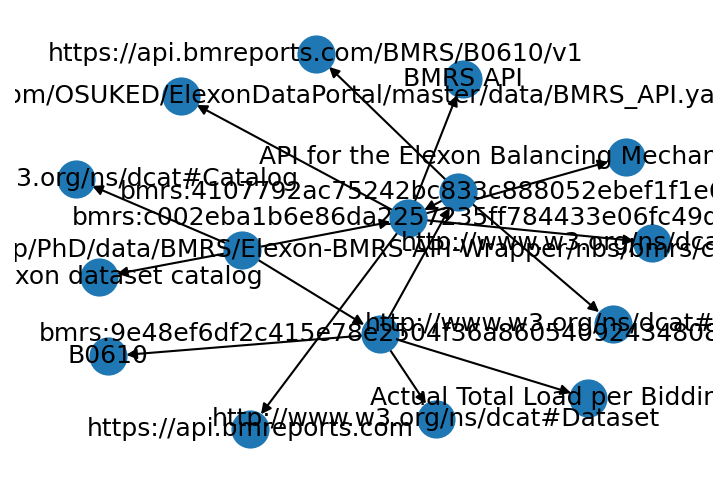

In [47]:
G = rdflib_to_networkx_multidigraph(g)

# Plot Networkx instance of RDF Graph
fig, ax = plt.subplots(dpi=150)

pos = nx.spring_layout(G, scale=10, k=10, iterations=500)
edge_labels = nx.get_edge_attributes(G, 'r')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax)
nx.draw(G, with_labels=True, ax=ax)